In [2]:
# initialization
import matplotlib.pyplot as plt
import numpy as np
import math

# Qiskit
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, transpile
from qiskit.visualization import plot_histogram
from dotenv import load_dotenv
from qiskit.providers.basic_provider import BasicSimulator
from qiskit_aer import AerSimulator

# from qiskit.providers.ibmq import least_busy

# import basic plot tools
from qiskit.visualization import plot_histogram

# maze = [1, 0, 1, 0]
maze = [1, 0, 1, 1, 0, 1, 1, 0, 1]
# maze = [
#     [1, 0, 1, 1, 1, 1, 1, 1],
#     [1, 0, 0, 0, 0, 0, 0, 1],
#     [1, 1, 0, 1, 1, 0, 1, 1],
#     [1, 0, 1, 1, 1, 0, 1, 1],
#     [1, 0, 0, 0, 0, 0, 0, 1],
#     [1, 1, 1, 1, 0, 1, 1, 1],
#     [1, 0, 0, 0, 0, 0, 0, 1],
#     [1, 0, 1, 1, 1, 1, 1, 1],
# ]

In [ ]:
# Maze conversion
maze = np.array(maze)
maze = maze.flatten()

# Creating the maze circuit
n = 9
board_qubits = QuantumRegister(n, name="b")
var_qubits = QuantumRegister(n, name="v")
oracle = QuantumRegister(1, name="o")
auxiliary = QuantumRegister(n - 1, name="a")
cbits = ClassicalRegister(n, name="cbits")
qc = QuantumCircuit(board_qubits, var_qubits, oracle, auxiliary, cbits)

directions = [int(-math.sqrt(n)), 1, int(math.sqrt(n)), -1]
# UP  RIGHT  DOWN  LEFT

list_of_empty_squares = []

# Mark all 1s in the board
for square in range(n):
    if maze[square] == 1:
        qc.x(board_qubits[square])
    # If not a 1, add it to a list as an empty square that can be traversed
    else:
        list_of_empty_squares.append(square)

print(list_of_empty_squares)


# Create NOR Gate Oracle
def create_oracle(qc, n):
    # Connect all squares that are 0s and that are next to each other
    duplicate_list = []
    for q in range(n):
        for direction in directions:
            # Make sure index is actually in the list, also avoids wraparounds for negative list indices
            if 0 <= q + direction < len(maze):
                if maze[q] == 0 and maze[q + direction] == 0:
                    if (q, q) not in duplicate_list:
                        qc.cx(var_qubits[q], board_qubits[q])
                        duplicate_list.append((q, q))
                    else:
                        pass
                    if (q, q + direction) not in duplicate_list:
                        qc.cx(var_qubits[q + direction], board_qubits[q])
                        duplicate_list.append((q, q + direction))
                    else:
                        pass
    for q in range(n):
        qc.x(q)
    qc.mcx(
        board_qubits[list_of_empty_squares],
        oracle[0],
        auxiliary[0],
        mode="basic",
    )
    for q in range(n):
        qc.x(q)
    # Reverse cx gates

    for q in range(n):
        for direction in directions:
            # Make sure index is actually in the list, also avoids wraparounds for negative list indices
            if 0 <= q + direction <= len(maze):
                if maze[q] == 0 and maze[q + direction] == 0:
                    if (q, q) not in duplicate_list:
                        qc.cx(var_qubits[q], board_qubits[q])
                        duplicate_list.append((q, q))
                    else:
                        pass
                    if (q, q + direction) not in duplicate_list:
                        qc.cx(var_qubits[q + direction], board_qubits[q])
                        duplicate_list.append((q, q + direction))
                    else:
                        pass


# Initialize Superposition
qc.h(var_qubits)
qc.x(oracle[0])
qc.h(oracle[0])
qc.barrier()

# Iteration of Grover
for i in range(1):
    create_oracle(qc, n)
    qc.barrier()
    # Diffuser
    qc.h(var_qubits[:])
    qc.x(var_qubits[:])
    qc.h(var_qubits[n - 1])
    qc.mcx(var_qubits[0 : n - 1], var_qubits[n - 1], auxiliary[0 : n - 2], mode="basic")
    qc.h(var_qubits[n - 1])
    qc.x(var_qubits[:])
    qc.h(var_qubits[:])
    qc.barrier()


# Uncompute
qc.h(oracle[0])
qc.x(oracle[0])

qc.measure(var_qubits, cbits)
qc.reverse_bits()

print(qc.draw())

[1, 4, 7]
         ┌───┐      ░ ┌───┐┌───┐                                             »
    b_0: ┤ X ├──────░─┤ X ├┤ X ├─────────────────────────────────────────────»
         └───┘      ░ ├───┤└───┘┌───┐┌───┐                                   »
    b_1: ───────────░─┤ X ├─────┤ X ├┤ X ├────────────────────────────────■──»
         ┌───┐      ░ └─┬─┘┌───┐└─┬─┘├───┤                                │  »
    b_2: ┤ X ├──────░───┼──┤ X ├──┼──┤ X ├────────────────────────────────┼──»
         ├───┤      ░   │  ├───┤  │  ├───┤                                │  »
    b_3: ┤ X ├──────░───┼──┤ X ├──┼──┤ X ├────────────────────────────────┼──»
         └───┘      ░   │  └───┘  │  └───┘┌───┐┌───┐┌───┐┌───┐            │  »
    b_4: ───────────░───┼─────────┼───────┤ X ├┤ X ├┤ X ├┤ X ├────────────■──»
         ┌───┐      ░   │  ┌───┐  │  ┌───┐└─┬─┘└─┬─┘└─┬─┘└───┘            │  »
    b_5: ┤ X ├──────░───┼──┤ X ├──┼──┤ X ├──┼────┼────┼───────────────────┼──»
         ├───┤      ░   │  ├───┤  │  ├───┤

[('000010100', 19), ('100110011', 19), ('111101110', 19), ('000010101', 19), ('000110100', 18), ('011000000', 18), ('000110101', 18), ('101000110', 18), ('110010111', 17), ('110110110', 17), ('111011011', 17), ('001000111', 17), ('010101111', 17), ('100010110', 16), ('000010110', 16), ('101001000', 16), ('110100100', 16), ('001110001', 16), ('011111110', 16), ('001100100', 16), ('111001001', 16), ('111101000', 15), ('110100011', 15), ('101111000', 15), ('101100010', 15), ('110110001', 15), ('010100001', 15), ('110100101', 15), ('010011110', 15), ('001010011', 15), ('010001110', 15), ('010001001', 15), ('001100010', 15), ('111011010', 15), ('000101100', 15), ('011010000', 15), ('010101011', 14), ('100110000', 14), ('100111101', 14), ('111001110', 14)]


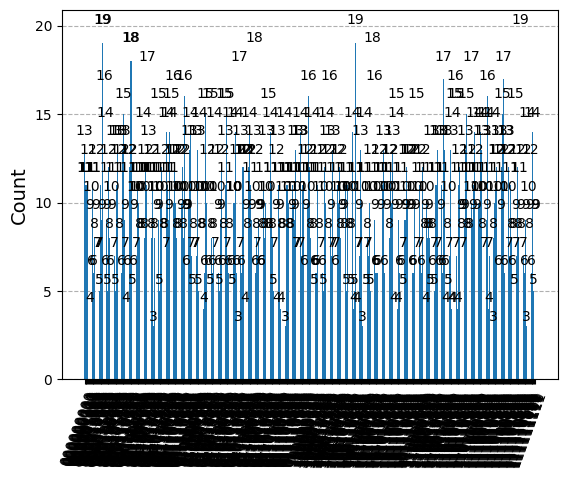

In [30]:
# Simulate and plot result
backend = AerSimulator()
transpiled_qc = transpile(qc, backend=backend)
result = backend.run(transpiled_qc, shots=5000).result()
counts = result.get_counts()
score_sorted = sorted(counts.items(), key=lambda x: x[1], reverse=True)
final_score = score_sorted[0:40]
print(final_score)
plot_histogram(counts)